## Chapter 10 - Petrological thermodynamics of liquid and solid phases

In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import numpy.matlib
from scipy.optimize import fsolve, fminbound
from scipy.interpolate import interp1d

## The equilibrium state

The partition coefficient $\parco_j$ is given by
\begin{equation*}
  \label{eq:equilibrium_partitioning_nonlinear}
  \parco_j = \left[\frac{\sum_k\left(\obar{\con}_k/\molarmass_k\right)\parco_k}
             {\sum_k\left(\obar{\con}_k/\molarmass_k\right)}\right]
             \exp\left[\frac{\Delta\enthalpy_j^{m}}{R/\molarmass_j}
             \left(\frac{1}{\temp} -
             \frac{1}{\melttemp_j}\right)\right].\nonumber
\end{equation*}

In cases where, for example, we use a small set of fictitious *effective* components to approximate the full thermochemical system, the error that we make in taking $\phasemolarmass\liq/\phasemolarmass\sol \approx 1$ is acceptably small. With this approach, the partition coefficient $\parco_j$ becomes

\begin{equation*}
  \label{eq:equilibrium_partitioning_simple}
  \parco_j(P,T) = \exp\left[\frac{\latent_j}{R_j}\left(\frac{1}{\temp} - \frac{1}{\melttemp_j(P)}\right)\right],
\end{equation*}

where $\latent_j\equiv-\Delta\enthalpy_j^m$ is the latent heat of melting for a solid composed of pure component $j$ and $R_j \equiv R/M_j$ is the modified gas constant.


Partition coefficients $\parco_j$ give an implicit equation for the equilibrium melt fraction $\equi\mf$ as

\begin{equation*}
  \label{eq:equilibrium-melt-frac-implicit}
  \sum_{j=1}^N\frac{\obar{\con}_j \left[1-\parco_j(\temp,\pres)\right]}{\equi\mf + (1-\equi\mf)\parco_j(\temp,\pres)} = 0,
\end{equation*}

Once a value of $\equi\mf$ has been numerically obtained, it can be used to determine the phase composition

\begin{align}
    \label{eq:equilib-phase-comp-liquid}
    \equi\con\liq_j &= \frac{\obar{\con}_j}{\equi\mf +
    (1-\equi\mf)\parco_j},\\
    \label{eq:equilib-phase-comp-solid}
    \equi\con\sol_j &= \frac{\obar{\con}_j}{\equi\mf/\parco_j +
                      (1-\equi\mf)}.
\end{align}


Table below shows parameter values for the two- and three-component ideal-solution systems. These values are useful for the demonstration of ideal-solution phase diagrams but should not be taken as an optimal calibration for the mantle.

| Name | $j$ | &nbsp; &nbsp; &nbsp; &nbsp; $\melttemp_j(P=0)$ [$^\circ$C] &nbsp; &nbsp; &nbsp; &nbsp; | $\clapeyron_j$ [GPa/K] | $\latent_j$ [kJ/kg] | $R_j$ [J/kg/K] |
|:---:|:---:|:---:|:---:|:---:|:---:|
| olivine | 1 | &nbsp; &nbsp; &nbsp; &nbsp; 1780 &nbsp; &nbsp; &nbsp; &nbsp; | 1/50 | 600 | 70 |
| basalt | 2 | &nbsp; &nbsp; &nbsp; &nbsp; 950 &nbsp; &nbsp; &nbsp; &nbsp; | 1/100 | 450 | 30 |
| hydrous basalt | 3 | &nbsp; &nbsp; &nbsp; &nbsp; 410 &nbsp; &nbsp; &nbsp; &nbsp; | 1/50 | 330 | 30 |

### Application to a two-pseudo-component system


The change of this melting temperature with pressure is given by the Clausius-Clapeyron equation. For simplicity, we assume a constant value of $\clapeyron = \Delta\entropy/\Delta(1/\density)$, which gives

\begin{equation}
  \label{eq:linear-solidus-relation}
  \temp^m_j(P) = \left.\temp^m_j\right\vert_{\pres=0} +
  \pres/\clapeyron.
\end{equation}

This produces the straight lines in Figure below (a) under the assumption that the thermodynamic pressure is lithostatic, i.e., $\Grad\pres=\density\gravity$.

In [2]:
class IdealSolutionParameters:
    def __init__(self, L, R, clap, Tm0):
        """
        par.L = latent heat in J/kg
        par.R = specific gas constant in J/kg/K
        par.Tm0 = melting point at P=0, K
        par.clap = Clapeyron slope in GPa/K
        """
        self.L = L        # J/kg
        self.R = R        # J/kg/K
        self.clap = clap  # GPa/K
        self.Tm0 = Tm0    # K

In [3]:
class ThetaStructure:
    def __init__(self, f=0, cl=None, cs=None):
        self.Ts = 0.0
        self.Tf = 0.0
        self.f = f  # f the melt fraction
        self.cl = cl  # liquid concentration vector (length n)
        self.cs = cs  # solid concentration vector (length n)

In [4]:
def ParCoef_IdealSolution(T, P, par):
    """
    % Partition coefficient from ideal solution theory
    %    returns K, the partition coefficient
    %    inputs: T, temperature in Kelvin
    %            P, pressure in GPa
    %            par, parameter struct including
    """
    Tm = par.Tm0 + P/par.clap
    return np.exp(par.L / par.R * (1./T - 1./Tm))

In [5]:
def EquilibriumResidual(TT, ff, PP, cc, par, parco_func):
    K = np.array([parco_func(TT, PP, par_j) for par_j in par]).flatten()
    R = np.array([cc_j * (1. - K_) / (ff + (1. - ff) * K_) for cc_j, K_ in zip(cc, K)])
    return R.sum()

In [12]:
def EquilibriumState(n, cbar, T, P, par, parco_func):
    """
    % Partition coefficient from ideal solution theory
    %    returns Theta structure containing
    %       Theta.f = the melt fraction
    %       Theta.cl = liquid concentration vector (length n)
    %       Theta.cs = solid concentration vector (length n)
    %    inputs: n, number of components
    %            cbar = bulk composition (length n or n-1)
    %            T, temperature in Kelvin
    %            P, pressure in GPa
    %            par, array of parameter structs of length n including
    %               par.L = latent heat in J/kg
    %               par.R = specific gas constant in J/kg/K
    %               par.Tm0 = melting point at P=0, K
    %               par.clap = Clapeyron slope in GPa/K
    %            parco_func = function handle for computing partition coefficient
    %               with interface K = parco_func(T,P,par)
    """

    if n == 1:
        raise Exception('n must be greater than 1')

    if len(par) < n:
        if len(par) == 1:
            par = [par] * n
        else:
            raise Exception('par array of structures must be length 1 or n')

    if isinstance(T, np.ndarray) and isinstance(P, np.float):
        P = P * np.ones_like(T)
    if isinstance(P, np.ndarray) and isinstance(T, np.float):
        T = T * np.ones_like(P)
    if isinstance(T, np.float) and isinstance(P, np.float):
        r = cbar.shape[0]
        T = np.ones((r,)) * T
        P = np.ones((r,)) * P
    if len(T) != len(P):
        raise Exception('length(T)={} and length(P)={} must be equal if both are greater than 1'.format(len(T), len(P)))

    r = len(T)
    if cbar.shape != (r, n) and cbar.shape != (1, n) and cbar.shape != (n,):
        raise Exception('one dimension of the cbar array must have length n')
    if cbar.shape == (n, r):
        cbar = cbar.transpose()
    if cbar.shape == (1, r) or cbar.shape == (n,):
        cbar = np.matlib.repmat(cbar, r, 1)
    if cbar.shape != (r, n):
        raise Exception('cbar must have shape ({}, {})'.format(r, n))

    Theta = []

    for T_i, P_i, cbar_i in zip(T, P, cbar):
        Theta_i = ThetaStructure()
        Theta_i.Ts = fsolve(lambda T_: EquilibriumResidual(T_, 0.0, P_i, cbar_i, par, ParCoef_IdealSolution), T_i)[0]
        Theta_i.Tl = fsolve(lambda T_: EquilibriumResidual(T_, 1.0, P_i, cbar_i, par, ParCoef_IdealSolution), 
                            0.5*(T_i+Theta_i.Ts))[0]

        if T_i < Theta_i.Ts:
            Theta_i.f = 0.0
        elif Theta_i.Tl < T_i:
            Theta_i.f = 1.0
        else:
            Theta_i.f = fsolve(lambda f_: EquilibriumResidual(T_i, f_, P_i, cbar_i, par, ParCoef_IdealSolution), 
                               0.0)[0]

        K = np.array([parco_func(T_i, P_i, par_j) for par_j in par])

        Theta_i.cl = cbar_i / (Theta_i.f + (1. - Theta_i.f)*K)
        Theta_i.cs = K * Theta_i.cl
        Theta.append(Theta_i)

    if len(Theta) != len(T):
        raise Exception('inconsistent number of ThetaStructure')

    return Theta

Ideal-solution model of a two-component system of _olivine_ ($j=1$) and _basalt_ ($j=2$). Parameter values are given in table above. __(a)__ Pure-component melting temperatures $\melttemp_j$ as a linear function of pressure. __(b)__ Partition coefficients $\parco_j$ as a function of temperature at a constant pressure of 1 GPa. __(c)__ Grey lines are the solidus and liquidus temperature as a function of the basalt fraction at a pressure of 1 GPa. The composition along the solidus curve refers to the solid phase; that along the liquidus curve refers to the liquid phase. Black lines indicate the compositional evolution of a closed system with bulk composition of 25% basalt component. __(d)__ Equilibrium melt fraction as a function of temperature for a bulk composition of 25% basalt component at 1 GPa.

In [13]:
par = [IdealSolutionParameters(600e3, 70., 1./50., 1780. + 273.), 
       IdealSolutionParameters(450e3, 30., 1./100., 950. + 273.)]

# thermodynamic state
Pref = 1.
Pvar = np.linspace(0., 7., 20)
Tref = 1350. + 273.
Tvar = np.linspace(1050., 1950., 200) + 273
cref = np.array([0.75, 0.25])
cvar = np.zeros((200, 2), dtype=np.float)
cvar[:, 0] = np.linspace(0., 1., 200)
cvar[:, 1] = 1.0 - np.linspace(0., 1., 200)

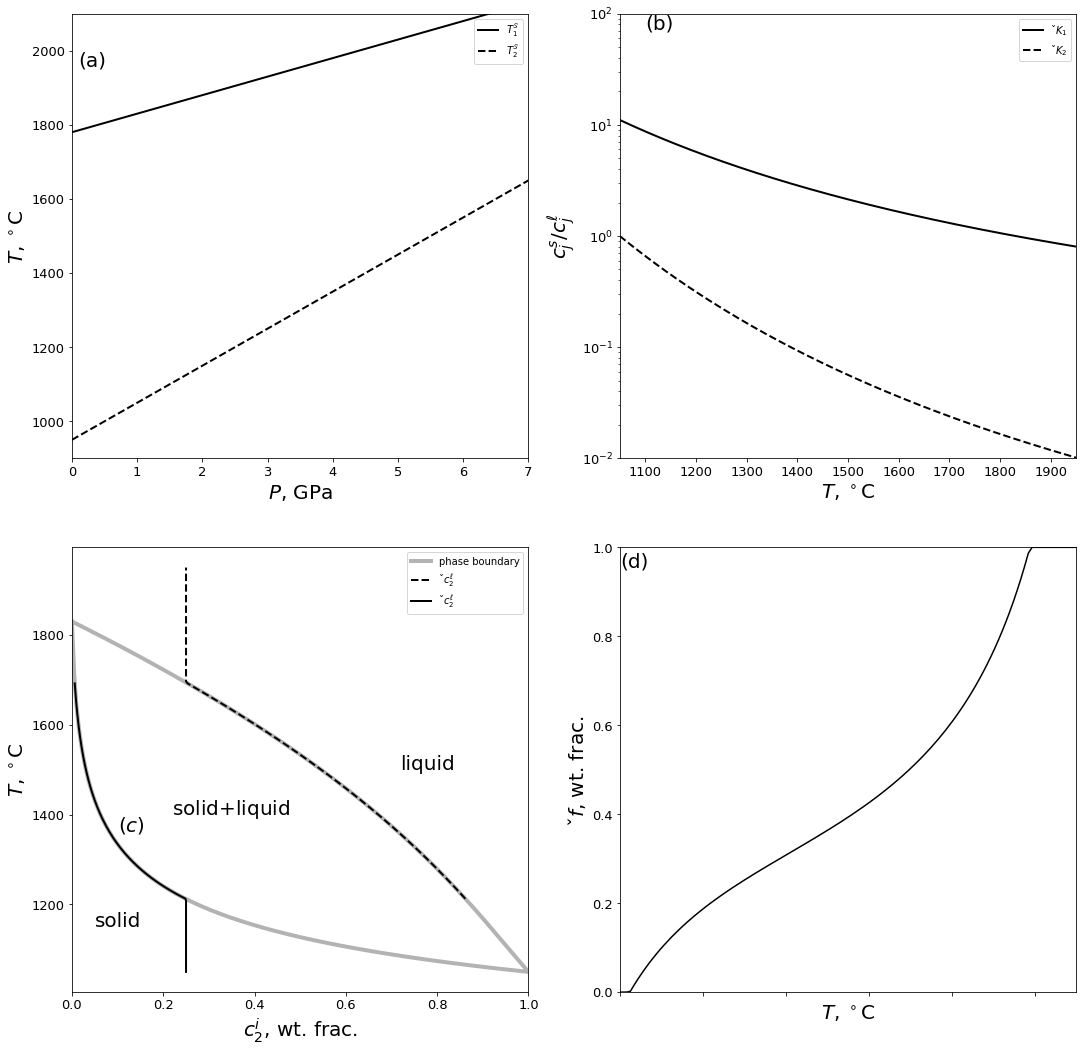

In [16]:
fig, ((axA, axB), (axC, axD)) = plt.subplots(nrows=2, ncols=2, figsize=(18.0, 18.0))

P  =  Pvar
T  =  Tref
c  =  cref
Tm = np.array([par_i.Tm0 + P/par_i.clap for par_i in par]).transpose()

axA.plot(P, Tm[:, 0]-273., '-k', linewidth=2, label=r'$T^\mathcal{S}_1$')
axA.plot(P, Tm[:, 1]-273., '--k', linewidth=2, label=r'$T^\mathcal{S}_2$')
axA.set_xlim(0.0, 7.0)
axA.set_xlabel('$P$, GPa', fontsize=20)
axA.set_ylim(900, 2100)
axA.set_ylabel(r'$T$, $^\circ$C', fontsize=20)
axA.text(0.1, 2000, r'(a)', fontsize=20, verticalalignment='top', horizontalalignment='left')
axA.tick_params(axis='both', which='major', labelsize=13)
axA.legend()

P  =  Pref
T  =  Tvar
c  =  cref
K = np.array([[ParCoef_IdealSolution(T_i, P, par_j) for par_j in par] for T_i in T])

axB.plot(T-273., K[:, 0], '-k', linewidth=2, label=r'$\check{K}_1$')
axB.plot(T-273., K[:, 1], '--k', linewidth=2, label=r'$\check{K}_2$')
axB.set_yscale('log')
axB.set_xlim(1050, 1950)
axB.set_xlabel(r'$T$, $^\circ$C', fontsize=20)
axB.set_ylim(0.01, 100)
axB.set_ylabel(r'${c}^s_j/{c}^\ell_j$', fontsize=20)
axB.text(1100, 99.0, r'(b)', fontsize=20, verticalalignment='top', horizontalalignment='left')
axB.tick_params(axis='both', which='major', labelsize=13)
axB.legend()

T = Tvar
P = Pref
c = cref
Theta = EquilibriumState(len(par), c, T, P, par, ParCoef_IdealSolution)

axD.plot(Tvar-273., [t.f for t in Theta],'-k','linewidth',2)
axD.set_xlim(1200., 1750.)
axD.set_xticks((1200, 1300, 1400, 1500, 1600, 1700))
axD.set_ylim(0.0, 1.0)
axD.set_xlabel(r'$T$, $^\circ$C', fontsize=20)
axD.set_ylabel(r'$\check{f}$, wt. frac.', fontsize=20)
axD.tick_params(axis='both', which='major', labelsize=13)
axD.text(1200.0, 0.99, r'(d)', fontsize=20, verticalalignment='top', horizontalalignment='left')

cl_hold = np.array([t.cl[1] for t in Theta])
cs_hold = np.array([t.cs[1] for t in Theta])
f_hold = np.array([t.f for t in Theta])
cl_hold[f_hold < 1e-6] = np.nan
cs_hold[1.-f_hold < 1e-6] = np.nan

c  = cvar
P  = Pref
T  = Tref
Theta2 = EquilibriumState(len(par), c, T, P, par, ParCoef_IdealSolution)

axC.plot(c[:, 1], [t.Ts - 273. for t in Theta2], '-', linewidth=4, color=[0.7, 0.7, 0.7])
axC.plot(c[:, 1], [t.Tl - 273. for t in Theta2], '-', label='phase boundary', linewidth=4, color=[0.7, 0.7, 0.7])

axC.plot(cl_hold, Tvar-273., '--k', label='$\check{c}^\ell_2$', linewidth=2)
axC.plot(cs_hold, Tvar-273., '-k', linewidth=2, label='$\check{c}^\ell_2$')
axC.set_xlim(0.0, 1.0)
axC.set_xlabel('${c}^i_2$, wt. frac.', fontsize=20)
axC.set_ylabel('$T$, $^\circ$C', fontsize=20)
axC.text(0.1, 1400, '$(c)$', fontsize=20, verticalalignment='top', horizontalalignment='left')
axC.text(0.22, 1400, 'solid$+$liquid', fontsize=20)
axC.text(0.72, 1500,'liquid', fontsize=20)
axC.text(0.05, 1150,'solid', fontsize=20)
axC.tick_params(axis='both', which='major', labelsize=13)
axC.legend()

plt.show()

### Approaching the eutectic phase diagram

A eutectic phase diagram compared with ideal-solution phase loops for different values of $R_2$. Other ideal-solution 
parameters are $R_1=60$ J/kg/K, $\latent_1=\latent_2=500$ kJ/kg. __(a)__ Solidus and liquidus curves computed with ideal solution theory compared with the eutectic solidus and liquidus. __(b)__ Isobaric melting curves computed based on the phase loops and the eutectic.

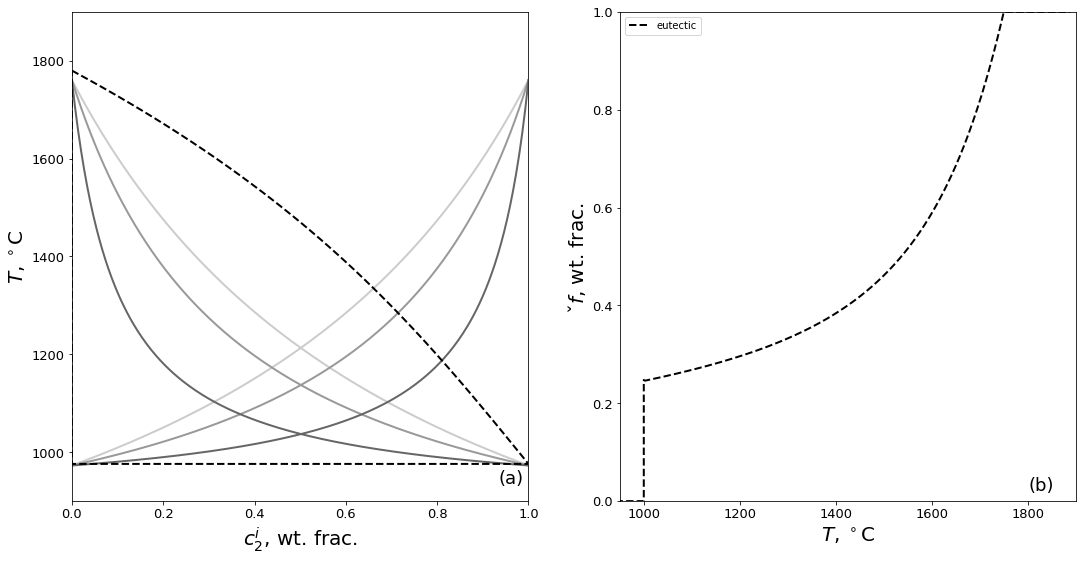

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18.0, 9.0)

r_dmc_calib = R_DMC_Calibration()

r2 = np.asarray([70, 50, 30, 10])
cI = len(r2) + 1
cp = 1200
sf = 0.3
H = np.linspace(-r_dmc_calib.L[0], r_dmc_calib.L[0] + cp * (r_dmc_calib.T0[0] - r_dmc_calib.T0[1]), 1000)

var = VAR()
var.C = np.zeros((r_dmc_calib.np, r_dmc_calib.nc))
var.C[:, 1] = np.linspace(0, 1, r_dmc_calib.np)
var.C[:, 0] = 1.0 - var.C[:, 1]
var.P = np.ones(r_dmc_calib.np) * r_dmc_calib.Pref
var.T = np.ones(r_dmc_calib.np) * r_dmc_calib.Tref
var.f = np.zeros(r_dmc_calib.np)

for i, r2i in enumerate(r2):
    r_dmc_calib.r[1] = r2i
    Tsol, Tliq = R_DMC_Equilibrium(var, r_dmc_calib, 'T')
    ax[0].plot(var.C[:, 0], Tsol, '-', linewidth=2, color=[1-i/cI, 1-i/cI, 1-i/cI])
    ax[0].plot(var.C[:, 1], Tliq, '-', linewidth=2, color=[1-i/cI, 1-i/cI, 1-i/cI])

T = np.linspace(r_dmc_calib.T0[0], r_dmc_calib.T0[1])
X = (T - r_dmc_calib.T0[1]) / (r_dmc_calib.T0[0] - r_dmc_calib.T0[1])
C_ = 1 - ((1 - sf) * X + sf * X ** 3)

ax[0].plot(np.hstack([C_, 0.0, 0.0]), np.hstack([T, r_dmc_calib.T0[1], r_dmc_calib.T0[0]]), '--k', linewidth=2)
ax[0].set_ylabel(r'$T$, $^\circ$C', fontsize=20)
ax[0].set_ylim(900, 1900)
ax[0].set_xlim(0.0, 1.0)
ax[0].set_xlabel(r'${c}^i_2$, wt. frac.', fontsize=20)
ax[0].text(0.99, 965.0, r'(a)', fontsize=18, verticalalignment='top', horizontalalignment='right')
ax[0].tick_params(axis='both', which='major', labelsize=13)

del var, T, X, C_

var = VAR()
var.T = r_dmc_calib.T_degC
var.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var.f = np.zeros(r_dmc_calib.np)
var.C = np.tile(r_dmc_calib.Cref, (r_dmc_calib.np, 1))
"""
for i, r2i in enumerate(r2):
    r_dmc_calib.r[1] = r2i
    f, _ = R_DMC_Equilibrium(var, r_dmc_calib, 'E')
    ax[1].plot(var.T, f, '-', linewidth=2, color=[1-i/cI, 1-i/cI, 1-i/cI], label=r'$R_2^*='+str(r2i)+'$ J/kg/K')
"""

H = np.linspace(-r_dmc_calib.L[0], r_dmc_calib.L[0] + cp * (r_dmc_calib.T0[0]-r_dmc_calib.T0[1]), 1000)
TE, FE = meltFractionEutectic(H, r_dmc_calib.Cref, 2000, 1000, 500e3, cp, r_dmc_calib, sf)
ax[1].plot(TE, FE, '--k', linewidth=2, label='eutectic')
ax[1].set_xlim(950, 1900)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel(r'$T$, $^\circ$C', fontsize=20)
ax[1].set_ylabel(r'$\check{f}$, wt. frac.', fontsize=20)
ax[1].text(1800.0, 0.05, r'(b)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].legend()

plt.show()

### Application to a three-pseudo-component system

Ideal-solution model of a three-component system of *olivine* ($j=1$), *basalt* ($j=2$) and *hydrous basalt* ($j=3$). Parameter values are given in table above. __(a)__ Pure-component melting temperatures $\melttemp_j$ as a linear function of pressure. __(b)__ Partition coefficients $\parco_j$ as a function of temperature at a constant pressure of 1 GPa. __(c)__ Surfaces are the solidus and liquidus temperature through the full, 3-component space at a pressure of 1 GPa. The composition along the solidus surface refers to the solid phase; that along the liquidus surface refers to the liquid phase. The compositional evolution of the melt for a closed system with 75 wt% olivine and 0.2 wt% hydrous basalt is shown by the solid line. It starts at the triangle and progresses toward the circle with increasing $\temp$ and $\equi\mf$. __(d)__ Equilibrium melt fraction as a function of temperature for a bulk composition of 75 wt% olivine component with and without 0.2 wt% of hydrated basalt component at 1 GPa.

Exception: R_DMC module: Newton solver for equilibrium melt fraction did not converge with step size 1.9073486328125e-06!

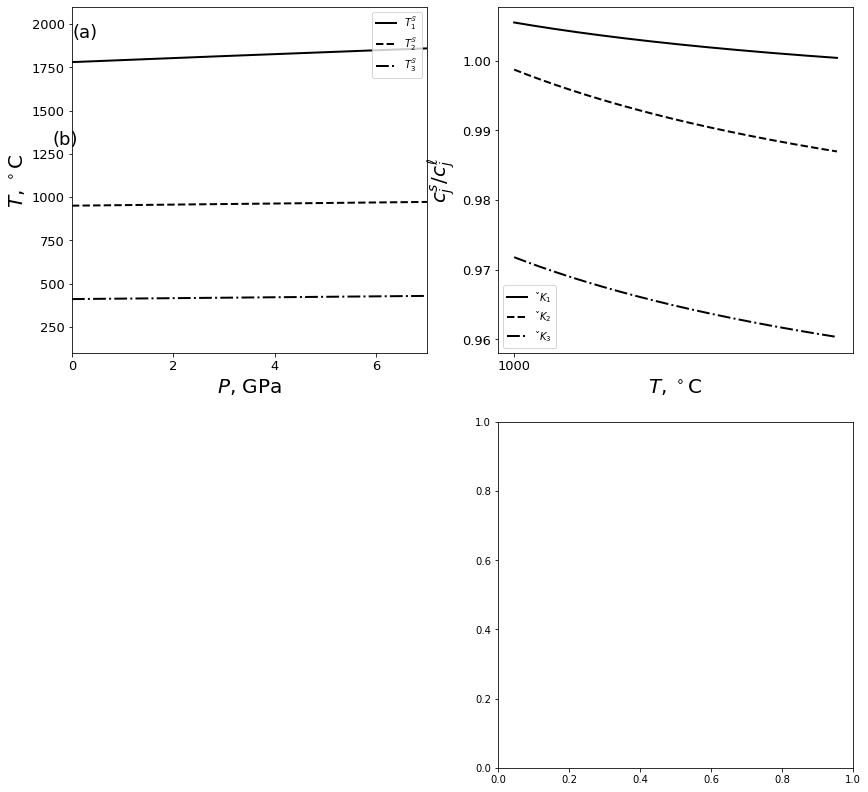

In [46]:
fig = plt.figure(figsize=plt.figaspect(2.))
gs = fig.add_gridspec(2, 2)
fig.set_size_inches(14.0, 14.0)

r_dmc_calib = R_DMC_Calibration(_nc=3, _np=400, _CompStr=['olivine', 'basalt', 'wet basalt'],
                                    _Tref=1350, _Tmin=1000, _Tmax=1700, _Pref=1, _Pmin=0, _Pmax=7,
                                    _Cref=[0.75, 0.248, 0.002], _T0=[1780, 950, 410], _A=[50, 100, 50], _B=[3, 3, 3],
                                    _L=[600e3, 450e3, 330e3], _r=[70, 30, 30])

var = VAR()
var.P = r_dmc_calib.P_GPa
var.T = np.ones(r_dmc_calib.np) * r_dmc_calib.Tref
var.C = r_dmc_calib.Cref

Tm, K = R_DMC_Equilibrium(var, r_dmc_calib, 'K')

ax00 = fig.add_subplot(gs[0, 0])

ax00.plot(var.P, Tm[:, 0], '-k', linewidth=2, label=r'$T^\mathcal{S}_1$')
ax00.plot(var.P, Tm[:, 1], '--k', linewidth=2, label=r'$T^\mathcal{S}_2$')
ax00.plot(var.P, Tm[:, 2], '-.k', linewidth=2, label=r'$T^\mathcal{S}_3$')
ax00.set_xlabel(r'$P$, GPa', fontsize=20)
ax00.set_ylabel(r'$T$, $^\circ$C', fontsize=20)
ax00.set_xlim(0, 7)
ax00.set_xticks((0, 2, 4, 6))
ax00.set_ylim(100, 2100)
ax00.text(0.01, 2000, '(a)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax00.tick_params(axis='both', which='major', labelsize=13)
ax00.legend()

del var, Tm, K

var = VAR()
var.T = r_dmc_calib.T_degC
var.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var.C = r_dmc_calib.Cref

Tm, K = R_DMC_Equilibrium(var, r_dmc_calib, 'K')

ax01 = fig.add_subplot(gs[0, 1])

ax01.plot(var.T, K[:, 0], '-k', linewidth=2, label=r'$\check{K}_1$')
ax01.plot(var.T, K[:, 1], '--k', linewidth=2, label=r'$\check{K}_2$')
ax01.plot(var.T, K[:, 2], '-.k', linewidth=2, label=r'$\check{K}_3$')
ax01.set_xlabel(r'$T$, $^\circ$C', fontsize=20)
ax01.set_xticks(np.arange(1000, 1701, 1000))
ax01.set_ylabel(r'${c}^s_j/{c}^\ell_j$', fontsize=20)
# ax[01].set_ylim(1e-4, 1e1)
# ax[01].set_yscale('log')
ax01.text(0.01, 0.99, r'(b)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax01.tick_params(axis='both', which='major', labelsize=13)
ax01.legend()

del var

ax11 = fig.add_subplot(gs[1, 1])

var_isobar = VAR()
var_isobar.T = r_dmc_calib.T_degC
var_isobar.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var_isobar.f = np.zeros(r_dmc_calib.np)
var_isobar.C = np.tile(r_dmc_calib.Cref, (r_dmc_calib.np, 1))
f_iso, _ = R_DMC_Equilibrium(var_isobar, r_dmc_calib, 'E')
var_isobar.Cs[1 - f_iso < 1e-6, :] = np.nan
var_isobar.Cl[f_iso < 1e-6, :] = np.nan
ax11.plot(var_isobar.T, f_iso, '-k', linewidth=2, label=r'wet')

var = VAR()
var.T = r_dmc_calib.T_degC
var.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var.f = np.zeros(r_dmc_calib.np)
var.C = np.tile(np.asarray([0.75, 0.25, 0.0]), (r_dmc_calib.np, 1))

f, _ = R_DMC_Equilibrium(var, r_dmc_calib, 'E')

var.Cs[1 - f < 1e-6, :] = np.nan
var.Cl[f < 1e-6, :] = np.nan
ax11.plot(var.T, f, '--k', linewidth=1, label='dry')
ax11.set_xlabel(r'$T$, $^\circ$C', fontsize=20)
ax11.set_ylabel(r'$\check{f}$, wt. frac.', fontsize=20)
ax11.set_xaxis(1000, 1500)
ax11.set_yaxis(0.0, 0.4)
ax11.text(0.01, 0.99, '(d)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.legend()

del var, f

ax10 = fig.add_subplot(gs[1, 0], projection='3d')

C3 = np.linspace(0, 1, r_dmc_calib.np)
C2 = np.linspace(0, 1, r_dmc_calib.np)
C2, C3 = np.meshgrid(C2, C3)
C2, C3 = C2.transpose().flatten(), C3.transpose().flatten()
C1 = 1 - C2 - C3
var = VAR()
var.C = np.zeros((r_dmc_calib.np * r_dmc_calib.np, r_dmc_calib.nc))
var.C[:, 0] = C1
var.C[:, 1] = C2
var.C[:, 2] = C3
var.P = np.ones(r_dmc_calib.np * r_dmc_calib.np) * r_dmc_calib.Pref
var.T = np.ones(r_dmc_calib.np * r_dmc_calib.np) * r_dmc_calib.Tref

Tsol, Tliq = R_DMC_Equilibrium(var, r_dmc_calib, 'T')

Tsol[var.C[:, 1] + var.C[:, 2] > 1] = np.nan
Tliq[var.C[:, 1] + var.C[:, 2] > 1] = np.nan
ax10.plot([0, 1, 0.5, 0], [0, 0, np.sin(1 / 3 * np.pi), 0], color=[0, 0, 0])
m = 5
grids = np.linspace(0, 100, m + 1)
grids = grids[0:-1]
labels = str(grids[1:])
x3, y3 = terncoords(100 - grids, grids, np.zeros(len(grids)))
x2, y2 = terncoords(grids, np.zeros(len(grids)), 100 - grids)
x1, y1 = terncoords(np.zeros(len(grids)), 100 - grids, grids)
n = m - 1
for i in np.arange(1, m):
    ax10.plot([x1[i], x2[n - i + 1]], [y1[i], y2[n - i + 1]], 'k:')
    ax10.plot([x2[i], x3[n - i + 1]], [y2[i], y3[n - i + 1]], 'k:')
    ax10.plot([x3[i], x1[n - i + 1]], [y3[i], y1[n - i + 1]], 'k:')
X, Y = terncoords(var.C[:, 1], var.C[:, 2], var.C[:, 0])
triangles = simpletri(r_dmc_calib.np)
tri = mtri.Triangulation(X.ravel(), Y.ravel(), triangles)
#ax10.plot_trisurf(tri, Tsol)
#ax10.plot_trisurf(tri, Tliq)
ax10.text(x3[1:]+0.09, y3[1:]-0.04, labels, fontsize=15)
ax10.text(x2[1:]+0.04, y2[1:]-0.12, labels, fontsize=15)
ax10.text(x1[1:]-0.09, y1[1:]+0.02, labels, fontsize=15)
ax10.text(0.44, 0.9, '${c}_3^i$', fontsize=15)
ax10.text(1.18, -0.09, '${c}_2^i$', fontsize=15)
ax10.text(-0.13, -0.030, '${c}_1^i$', fontsize=15)
ax10.plot(ternplot(var_isobar.Cl[:, 1], var_isobar.Cl[:, 2], var_isobar.Cl[:, 0]), '-k', linewidth=2)
ax10.plot(ternplot(r_dmc_calib.Cref[1], r_dmc_calib.Cref[2], r_dmc_calib.Cref[0]), 'ok', linewidth=2, markersize=8)
ax10.plot(ternplot(var_isobar.Cl[0, 1], var_isobar.Cl[0, 2], var_isobar.Cl[0, 0]), '<k', linewidth=2, markersize=8)
ax10.text(0.01, 0.99, '(c)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax10.tick_params(axis='both', which='major', labelsize=13)

plt.show()

### Linearising the two-component phase diagram

Phase diagrams constructed with ideal solution theory provide a useful basis for developing the melting relations required for magma/mantle dynamics. Their nonlinearity, however, precludes a use in analytical calculations; instead they must be handled numerically. It is therefore important to formulate an approximation in which the equilibrium state is computed analytically.

For linear variations in pressure and composition, we can write

  \begin{align}
    \label{eq:col-twocomp-pd-solidus}
    \soltemp &= \soltemp_\text{ref} + (\pres-\pres_\text{ref})/\clapeyron  +
               \solslope\left(\equi\con\sol - \equi\con\sol_{\text{ref}}\right),\\
  \label{eq:col-twocomp-pd-deltac}
    \equi\con\liq &= \equi\con\sol - \Delta\equi\con,
  \end{align}

where $\solslope$ is the constant slope of the solidus with concentration in the two component space and $\soltemp_\text{ref}$ is a reference temperature at $\pres=\pres_\text{ref}$ and $\equi\con\sol=\equi\con\sol_\text{ref}$.  Also, $\Delta\equi\con \equiv \equi\con\sol - \equi\con\liq$ is the concentration difference between the solidus and the liquidus.  If $\Delta\equi\con$ is taken to be a constant then the liquidus slope $\liqslope$ and the solidus slope $\solslope$ are equal.



Figure below plots a comparison of a two-component, ideal-solution phase loop with a linearised solidus and liquidus at 1 GPa. The phase loop uses the parameters from the Table above. __(a)__ Solidus and liquidus curves.  Evolution of an initially unmolten rock with 25 wt% basaltic component for increasing temperature, along the linearised phase boundaries. __(b)__ Isobaric melting curves.

/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeW

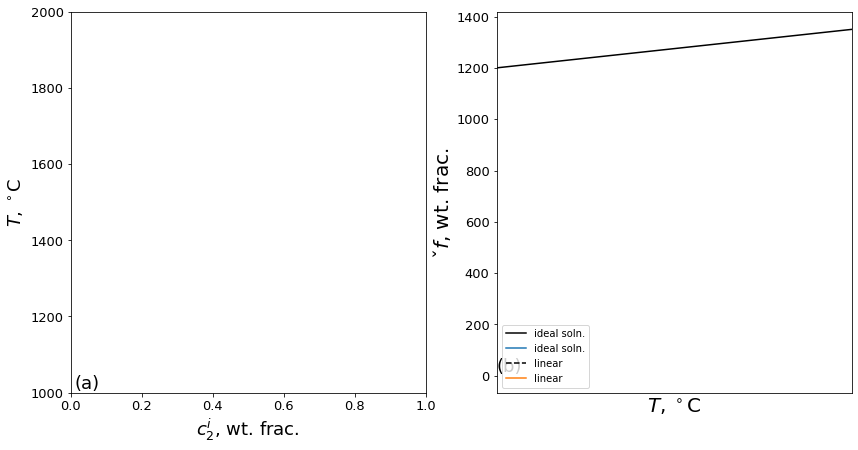

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14.0, 7.0)

r_dmc_calib = R_DMC_Calibration(_Tref=1350, _Tmin=900, _Tmax=1350, _Cref=[0.75, 0.25], _Pref=1, _Pmin=0, _Pmax=7,
                                    _T0=[1780, 950], _A=[45, 112], _B=[0, 0], _L=[600e3, 450e3], _r=[70, 30])

var = VAR()
var.C = np.zeros((r_dmc_calib.np, r_dmc_calib.nc))
var.C[:, 1] = np.linspace(0, 1, r_dmc_calib.np)
var.C[:, 0] = 1.0 - var.C[:, 1]
var.P = np.ones(r_dmc_calib.np) * r_dmc_calib.Pref
var.T = np.ones(r_dmc_calib.np) * r_dmc_calib.Tref

Tsol, Tliq = R_DMC_Equilibrium(var, r_dmc_calib, 'T')

Cint = r_dmc_calib.Cref[1] * np.asarray([0.999, 1.001])
Tint = interp1d(var.C[:, 1], Tsol)(Cint)
MS = (Tint[1] - Tint[0]) / (Cint[1] - Cint[0])
Tref = np.mean(Tint)
Cint = interp1d(Tliq, var.C[:, 1])(Tint)
ML = (Tint[1] - Tint[0]) / (Cint[1] - Cint[0])
Cref = np.mean(Cint)
F, Cs, Cl, = MeltFraction(r_dmc_calib.T_degC, r_dmc_calib.Cref[1], ML, MS, Cref, r_dmc_calib.Cref[1], Tref)

gr = 0.6
ax[0].plot(var.C[:, 1], Tsol, '-', linewidth=3, color=[gr, gr, gr])
ax[0].plot(var.C[:, 1], Tliq, '-', linewidth=3,
           color=[gr, gr, gr], label=r'$T^\mathcal{S},T^\mathcal{L}$ (ideal soln.)')
ax[0].plot(var.C[:, 1], SolLiqTemperature(var.C[:, 1], Cref, ML, Tref), '--',
           color=[gr, gr, gr], linewidth=3, label=r'$T^\mathcal{S},T^\mathcal{L}$ (linear)')
ax[0].plot(var.C[:, 1], SolLiqTemperature(var.C[:, 1], r_dmc_calib.Cref[1], MS, Tref), '--',
           color=[gr, gr, gr], linewidth=3)
ax[0].plot(Cs, r_dmc_calib.T_degC, '-k', linewidth=1.5, label=r'$\check{c}^s_2(T),\check{c}^\ell_2(T)$, (linear)')
ax[0].plot(Cl, r_dmc_calib.T_degC, '-k', linewidth=1.5)
ax[0].set_ylabel(r'$T$, $^\circ$C', fontsize=18)
ax[0].set_xlabel(r'${c}^i_2$, wt. frac.', fontsize=18)
ax[0].text(0.01, 1000, r'(a)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(1000, 2000)
ax[0].tick_params(axis='both', which='major', labelsize=13)

del var

var = VAR()
var.T = r_dmc_calib.T_degC
var.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var.f = np.zeros(r_dmc_calib.np)
var.C = np.tile(r_dmc_calib.Cref, (r_dmc_calib.np, 1))
f, _ = R_DMC_Equilibrium(var, r_dmc_calib, 'E')
ax[1].plot(var.T, f, '-k', 'linewidth', 2, label='ideal soln.')
ax[1].plot(var.T, F, '--k', 'linewidth', 2, label='linear')
ax[1].set_xlabel(r'$T$, $^\circ$C', fontsize=20)
ax[1].set_ylabel(r'$\check{f}$, wt. frac.', fontsize=20)
ax[1].text(1200, 0.01, r'(b)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')
ax[1].set_xlim(1200, 1350)
ax[1].tick_params(axis='both', which='major', labelsize=13)

plt.legend()
plt.show()